In [9]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

<b>Import</b>

In [10]:
#df = pd.read_csv("Historical_plague_outbreaks.txt", delimiter=',', encoding='latin1')
df=pd.read_csv("deaths-in-wars.csv")
df.head()

,Entity,Code,Year,Deaths in ongoing wars (low estimate) - Conflict type: civil war,Deaths in ongoing wars (low estimate) - Conflict type: others (non-civil)
0,Americas,NaN,1800,0,0
1,Americas,NaN,1801,0,0
2,Americas,NaN,1802,0,0
3,Americas,NaN,1803,0,0
4,Americas,NaN,1804,0,0


<b>Cleanup</b>

In [11]:
#According to Correlation/phiks matrix, volume is pretty useleless and has low relevance, imma drop it like its hot
df=df.drop('Volume',axis=1)
df=df.drop('Close',axis=1)
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

#trusting the autoviz blindly i will cap some outliers?
df['Open'] = df['Open'].clip(lower=-55, upper=97)
df['High'] = df['High'].clip(lower=-55, upper=97)
df['Low'] = df['Low'].clip(lower=-55, upper=97)
df['Adj_Close'] = df['Adj_Close'].clip(lower=-45, upper=75)

#correlation is probably a bit unreliable since all the data has the same distribution
# i can probabbly drop everything except 1 sicne the distribution and correlation is almost the same
# but yk that prob wouldnt be that fun

KeyError: "['Volume'] not found in axis"

In [ ]:
df.head()

,Date,Open,High,Low,Adj_Close
0,1986-03-13,0.088542,0.101563,0.088542,0.061434
1,1986-03-14,0.097222,0.102431,0.097222,0.063628
2,1986-03-17,0.100694,0.103299,0.100694,0.064725
3,1986-03-18,0.102431,0.103299,0.098958,0.063079
4,1986-03-19,0.099826,0.100694,0.097222,0.061982


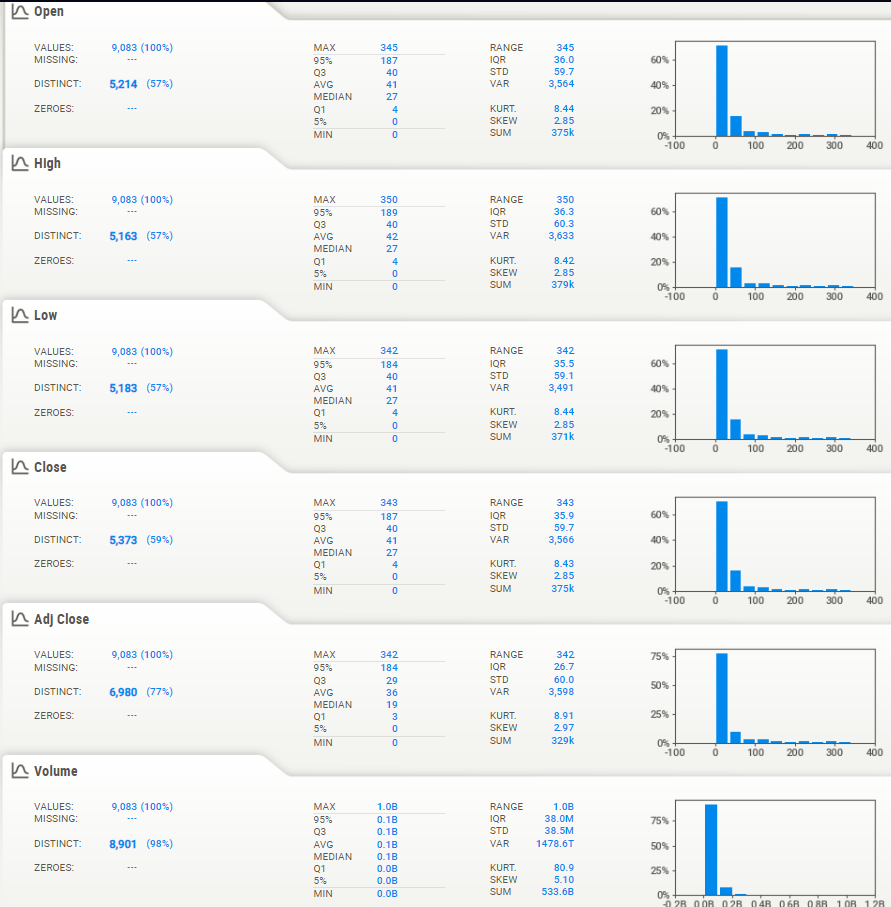

<b>seperation</b>

In [ ]:
#Legacy Code: i messed up by thinking for time series we need seperated train test from the begnning, so i looked at stack overflow to see how to split it



#train_set, test_set= np.split(df, [int(.67 *len(df))])
#df1=train_set
#df2=test_set
#i know i could have just set df1,df2 instead of train_set for simplifying, but i didnt want to loose overwie of wich is the train wich is the test




In [ ]:
df.head()

,Date,Open,High,Low,Adj_Close
0,1986-03-13,0.088542,0.101563,0.088542,0.061434
1,1986-03-14,0.097222,0.102431,0.097222,0.063628
2,1986-03-17,0.100694,0.103299,0.100694,0.064725
3,1986-03-18,0.102431,0.103299,0.098958,0.063079
4,1986-03-19,0.099826,0.100694,0.097222,0.061982


In [ ]:
df.describe()

,Open,High,Low,Adj_Close
count,9083.000000,9083.000000,9083.000000,9083.000000
mean,31.332719,31.566163,31.100185,24.046986
std,29.263914,29.309335,29.212965,23.742183
min,0.088542,0.092014,0.088542,0.057046
25%,4.050781,4.102051,4.027344,2.575089
50%,26.820000,27.100000,26.520000,18.948530
75%,40.034999,40.443751,39.500000,29.244812
max,97.000000,97.000000,97.000000,75.000000


In [ ]:
# this dataformat is not suitable yet for CNN time series classification
# because each point is separate in the dataset

# we have to process the data into smaller chunks -> for example
# chunks of 50 points at a time

# we are going to select High Low as targets, sicne those are the min max of the day, i think maybe the cnn can wortk best with taht?
df = df.drop(['Open','Adj_Close'], axis=1)


In [ ]:
df.head()

,Date,High,Low
0,1986-03-13,0.101563,0.088542
1,1986-03-14,0.102431,0.097222
2,1986-03-17,0.103299,0.100694
3,1986-03-18,0.103299,0.098958
4,1986-03-19,0.100694,0.097222


<b>Value scale</b>

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# cale only relevant variables
num_cols = ['High', 'Low']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df.head()

,Date,High,Low
0,1986-03-13,0.000099,0.000000
1,1986-03-14,0.000107,0.000090
2,1986-03-17,0.000116,0.000125
3,1986-03-18,0.000116,0.000107
4,1986-03-19,0.000090,0.000090


In [ ]:
df.tail()

,Date,High,Low
9078,2022-03-18,1.0,1.0
9079,2022-03-21,1.0,1.0
9080,2022-03-22,1.0,1.0
9081,2022-03-23,1.0,1.0
9082,2022-03-24,1.0,1.0


<b>Timestamps</b>

<p>I am not sure what to use windows or timeframes, sicne i have 9k data, imma use both to compare, pretty sure in the excercise we should do both anyway</p>
<s>Sometimes when writing these messages i feel like i am not erious enough, and that that might affect my grade, but alsoits after midnight so yeah gotta keep my mood somehow shrugy</s>

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 20

# separate the output variables
high = df['High'].values
low = df['Low'].values

# generate timestep windows for each signal

# for separate timesteps, add [::timestep_size] for each dataset (meantemp_windows, wind_speed_windows)
# e.g. meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)[::timestep_size]
# this filters every 50th (timestep_size) of a Python list
# which results into a set of timesteps with no overlap! (in sequence)

# RULE OF THUMB! If you have lots of data => use separate timesteps to avoid redundancy in data
# If you lack data, use sliding window instead (to get more data, but also having redundancy introduced)
# using separate time steps will also discard any extra data that doesn't fill the final timestep
# in this case, there's 25 extra measurements in the end, and since timestep_size is 50, these 25 are discarded
high_windows = sliding_window_view(high, window_shape=timestep_size)[::timestep_size]
low_windows = sliding_window_view(low, window_shape=timestep_size)[::timestep_size]

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((high_windows, low_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(high_windows) + [1] * len(low_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (362, 50)
y: (362,)


In [ ]:
from sklearn.utils import shuffle

# shuffle the data
X, y = shuffle(X, y, random_state=42)

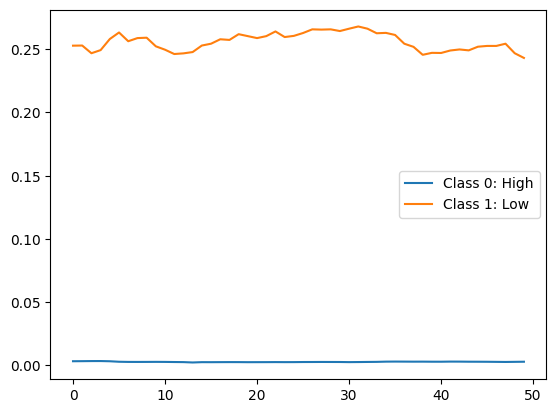

In [ ]:
test_signal_index = 2

c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0: High")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1: Low")
plt.legend()

weird that the "highest sell price for the day" is lower than the "lowest sellprice for the day" ?

<b>Train Split</b>

In [ ]:
 # define the cutoff point
train_size = 0.7
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

253
109
253
109


In [ ]:
# convert the data into the required CNN -format
# usuallu the easiest approach is to modify
# your own data to follow the data format used by another example 
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
class_names = np.array(["High", "Low"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(64, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])

# pip install pydot -> restart Kernel
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.5091 - val_loss: 0.6957 - val_sparse_categorical_accuracy: 0.4510
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7149 - sparse_categorical_accuracy: 0.4818 - val_loss: 0.6951 - val_sparse_categorical_accuracy: 0.4706
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7044 - sparse_categorical_accuracy: 0.4956 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.5098
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6984 - sparse_categorical_accuracy: 0.4877 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.4510
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6956 - sparse_categorical_accuracy: 0.4992 - val_loss: 0.6955 - val_sparse_categorical_accuracy: 0.4706
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.4850 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.4510
Epoch 7/500
7/7 

<Axes: >

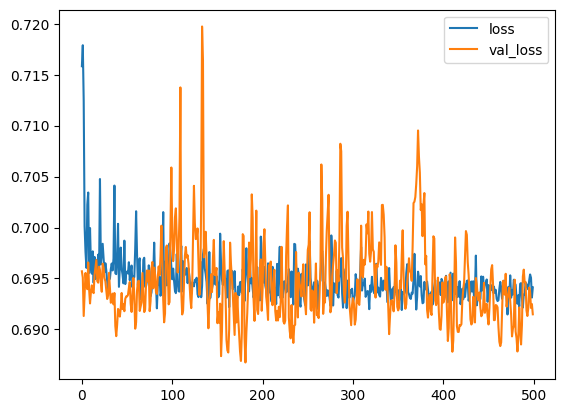

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<b>1. run</b>
honestly, i am not suprised anymore, wtf?
okay yeah is to be expected since stock is not really predictable

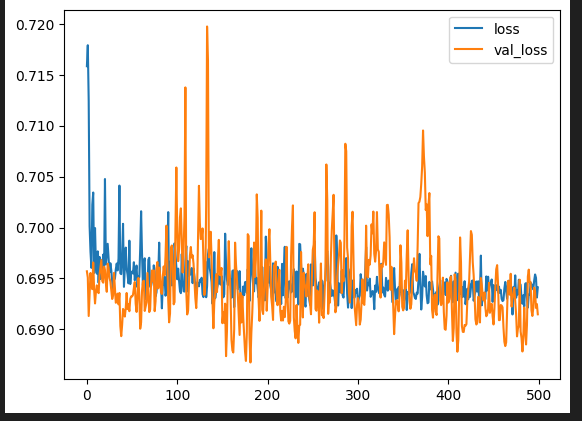

<Axes: >

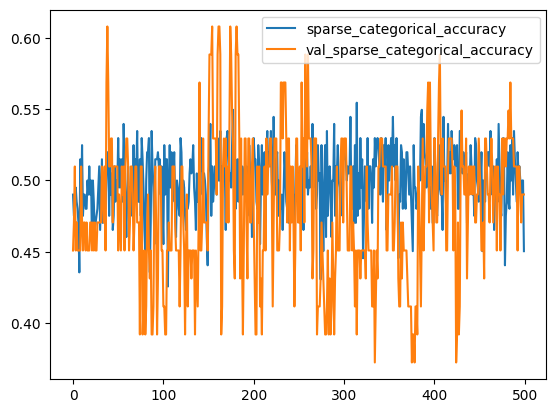

In [ ]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

<b>1.</b>
yeah i guess at least a bit system in the chaos

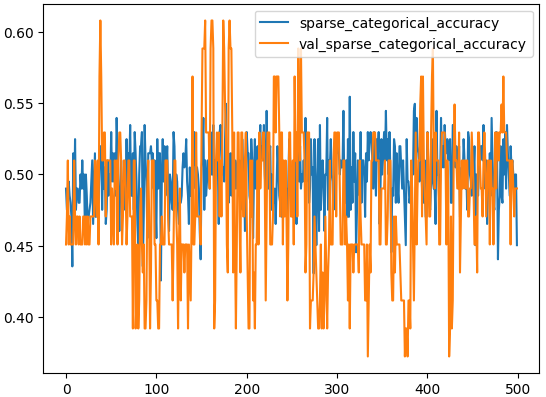

In [ ]:
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.6998749375343323, 0.44954127073287964]

Train data evaluation:
[0.6928135752677917, 0.5098814368247986]


In [ ]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


<Axes: >

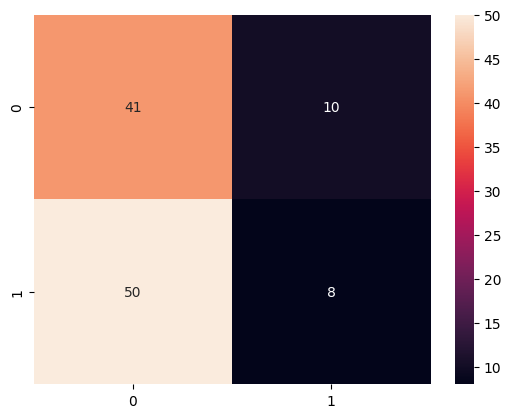

In [ ]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

<b>1.</b>
<p>I am not sure if the confusion matrix is usable since high is highest price, and low is lowest price, so its not really a cathegory to put into, so true negative and true positive make nosense?
<br>Anyway 0 = high so 41 where correctly classieief as high ????? the longer i try to interpret it the more it seems not working?
<br> 10 where said as high but where low ?????
<br>8 correct low and 50 incorrect low?????
</p>

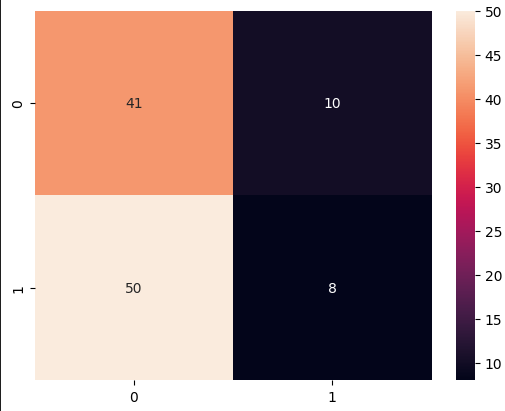

In [ ]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.45      0.80      0.58        51
           1       0.44      0.14      0.21        58

    accuracy                           0.45       109
   macro avg       0.45      0.47      0.39       109
weighted avg       0.45      0.45      0.38       109


Model overall accuracy: 44.95%


<ul><b>Notes</b>
<li>1. Run <ul>
<li><p>Most of the high confusion matrix is correct, most of the low confusion matrix is </p></li>
<li>Overall: <ul>
<li>Precicion: for all clases over 45%</li> 
<li>Recall: for 0 is 0.80 and 1 is 14% wich is not really good</li>
<li>F1:58% and 21%</li>
<li>Overall accuracy 45% wich is awefull, and flipping a coin would be better, this is to be expected since it is stocks and also because the correlation is basically 1</li></ul></li>
</ul></li>

</ul>

<b>Test the model</b>

0
High


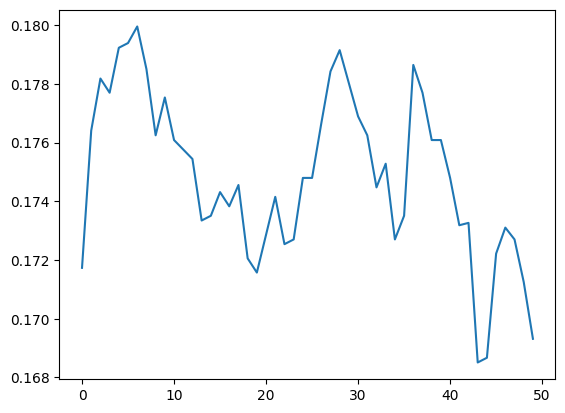

In [ ]:
signal_index = 80
print(y_test[signal_index])
print(class_names[y_test[signal_index]])

plt.figure()
plt.plot(x_test[signal_index])
plt.show()

<b>1. 60</b>
<p>Classification as Low</p>
<b>2.80</b>
<p>Classification High</p>

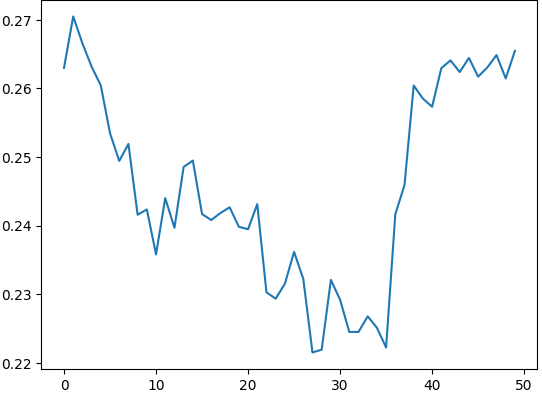
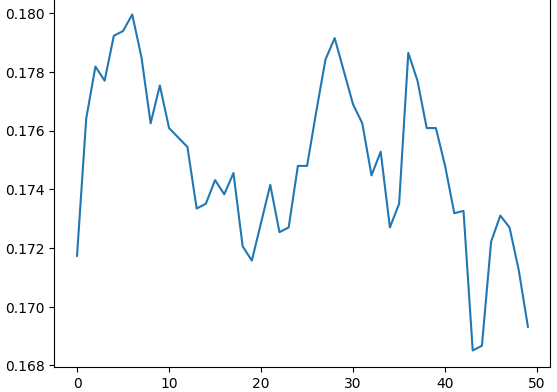

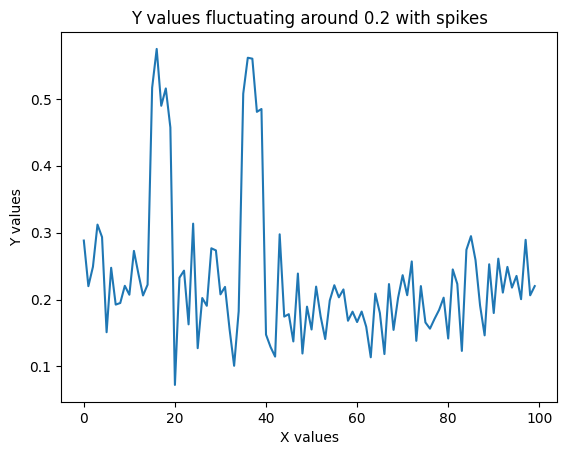